<a href="https://colab.research.google.com/github/Valiev-Koyiljon/InsurancePrice-Prediction-Pytorch/blob/main/InsurancePricePrediction_linearRegression_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance cost prediction using linear regression

we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training (data cleaning, EDA Visualization, Data Preprocessing, etc)
3. Create a linear regression model
4. Train the model to fit the data
5. Testing the model using Test dataset
6. Make predictions using the trained model




In [165]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore and clean the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file.

In [166]:
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


We will load the dataset by using the `read_csv` function from the `pandas` library.

In [167]:
dataframe= pd.read_csv(DATA_FILENAME)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [168]:
dataframe.describe() # to get statistical info

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [169]:
# info about data
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [170]:
#number of rows and cols
dataframe.shape

(1338, 7)

## Data Cleaning
Data cleaning is the process of identifying and correcting errors, inconsistencies, and inaccuracies in a dataset to ensure that it is accurate, reliable, and ready for analysis. In a Colab notebook, data cleaning involves tasks like handling missing values, removing duplicates, correcting invalid entries, and transforming data into a usable format. This prepares the data for meaningful insights and reliable machine learning models.

In [171]:
#checking for any duplicates in the dataset
dataframe.duplicated().sum()

1

In [172]:
duplicate_rows = dataframe[dataframe.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [173]:
# Drop duplicates based on all columns
df_no_duplicates = dataframe.drop_duplicates()
print("DataFrame after dropping duplicates:")
print(df_no_duplicates)

DataFrame after dropping duplicates:
      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1337 rows x 7 columns]


As you see above, our one row is deleted and shape is changed to 1337 from 1338

In [174]:
#checking the  null values
dataframe.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Now, we will separate the columns for the input variable

In [175]:
input_cols = dataframe[['age', 'sex', 'bmi', 'children', 'smoker']].columns
input_cols


Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')


We will list the columns that are non-numerical or categorical variables.

In [176]:
categorical_cols = ["sex", "smoker"]

We will separe the column name of output/target variable(s) for the training

In [177]:
output_cols = ["charges"]
output_cols

['charges']

To get info about our target variable, we will find the minimum, maximum and average
value of the `charges` column

In [178]:
# minimum
output_cols_min  = dataframe[output_cols].min()
output_cols_min

charges    1121.8739
dtype: float64

In [179]:
# maximum
output_cols_max  = dataframe[output_cols].max()
output_cols_max

charges    63770.42801
dtype: float64

In [180]:
# average
output_cols_aver  = dataframe[output_cols].mean()
output_cols_aver

charges    13270.422265
dtype: float64

# EDA Visualization

It is time to check  the distribution of the values in some columns and visualize it using **Seaborn**.


Distribution Observed In Dataset Type: female



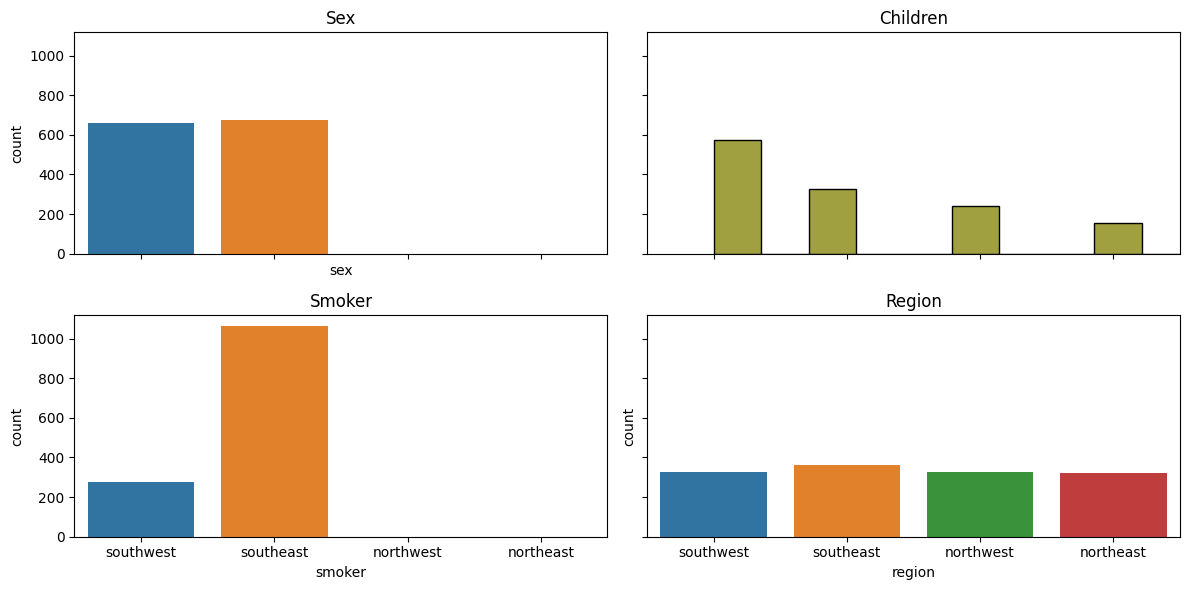

In [181]:
def distribution(x):
    cls = x.sex[0]  # Assuming 'sex' is representative of the class

    print(f"\033[1m\nDistribution Observed In Dataset Type: {cls}\033[0m\n")
    fig, (( ax2, ax4), ( ax5, ax6)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
    sns.countplot(x="sex", data=x, ax=ax2)
    ax2.set_title("Sex")
    sns.histplot(x["children"], color="olive", ax=ax4)
    ax4.set_title("Children")
    sns.countplot(x="smoker", data=x, ax=ax5)
    ax5.set_title("Smoker")
    sns.countplot(x="region", data=x, ax=ax6)
    ax6.set_title("Region")

    plt.tight_layout()

distribution(dataframe)


we will see the descriptive statistics and frequency of "charges" column, which will be our target variable, while we are training the model.

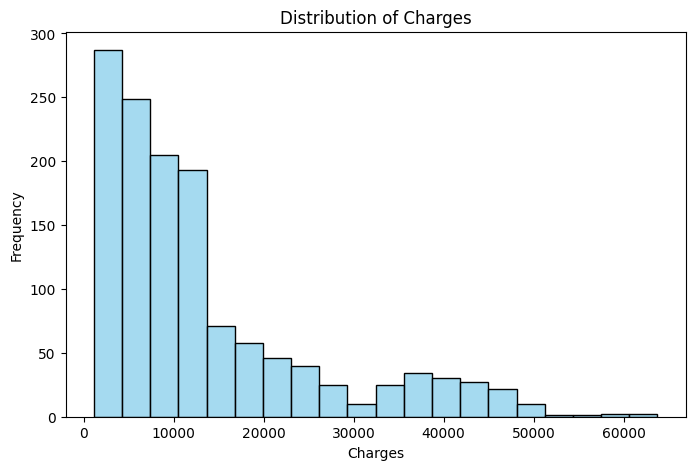

Descriptive statistics for 'charges' column:
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


In [182]:
charges_stats = dataframe['charges'].describe() # descriptive statistics for "charges" column.


plt.figure(figsize=(8, 5))
sns.histplot(dataframe['charges'], bins=20, color='skyblue')
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()
print("Descriptive statistics for 'charges' column:")
print(charges_stats)


### Removing the outliers

We will see  the outliers from the "Charges" column, which is our target variable.

Outliers in 'charges' column:
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     31    male  36.300         2    yes  southwest  38711.00000
30     22    male  35.600         0    yes  southwest  35585.57600
...   ...     ...     ...       ...    ...        ...          ...
1300   45    male  30.360         0    yes  southeast  62592.87309
1301   62    male  30.875         3    yes  northwest  46718.16325
1303   43    male  27.800         0    yes  southwest  37829.72420
1313   19  female  34.700         2    yes  southwest  36397.57600
1323   42  female  40.370         2    yes  southeast  43896.37630

[139 rows x 7 columns]


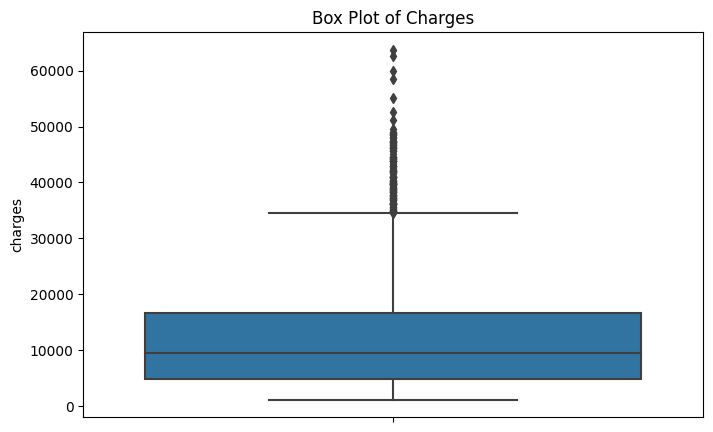

In [183]:

# IQR for charges column
Q1 = dataframe['charges'].quantile(0.25)
Q3 = dataframe['charges'].quantile(0.75)
IQR = Q3 - Q1



#outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR



outliers = dataframe[(dataframe['charges'] < lower_bound) | (dataframe['charges'] > upper_bound)]
print("Outliers in 'charges' column:")
print(outliers)



# visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=dataframe, y='charges')
plt.title('Box Plot of Charges')
plt.show()


Function to remove outliers from the a colum of the dataset

In [184]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_no_outliers = df.loc[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_no_outliers


Remove outliers from 'charges' column and we will call the dataframe without outliers as "df"

In [185]:
df = remove_outliers(dataframe, 'charges')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [186]:
print("Original DataFrame shape:", dataframe.shape)
print("DataFrame shape after removing outliers:", df.shape)

Original DataFrame shape: (1338, 7)
DataFrame shape after removing outliers: (1199, 7)


In [187]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Data Preprocessing

In [189]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


# numerical and categorical columns
numerical_cols = ['age', 'bmi', 'charges']
categorical_cols = ['sex', "smoker", ]



# label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])




# standard scaling to numerical columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



<ipython-input-189-b3f3c709d2cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-189-b3f3c709d2cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-189-b3f3c709d2cd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [190]:
df

,age,sex,bmi,children,smoker,region,charges
0,-1.421544,0,-0.365377,0,1,southwest,0.961182
1,-1.492656,1,0.611647,1,0,southeast,-1.133192
2,-0.781529,1,0.483485,3,0,southeast,-0.756865
3,-0.425965,1,-1.230051,0,0,northwest,1.665721
4,-0.497078,1,-0.202262,0,0,northwest,-0.837356
...,...,...,...,...,...,...,...
1333,0.782952,1,0.145605,3,0,northwest,0.092951
1334,-1.492656,0,0.303726,0,0,northeast,-1.066818
1335,-1.492656,0,1.124293,0,0,southeast,-1.146416
1336,-1.279318,0,-0.714908,0,0,southwest,-1.094178


## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [191]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [192]:

inputs_array, targets_array = dataframe_to_arrays(df)
inputs_array, targets_array

(array([[-1.42154365,  0.        , -0.36537683,  0.        ,  1.        ],
        [-1.49265642,  1.        ,  0.61164659,  1.        ,  0.        ],
        [-0.78152874,  1.        ,  0.48348509,  3.        ,  0.        ],
        ...,
        [-1.49265642,  0.        ,  1.12429261,  0.        ,  0.        ],
        [-1.27931812,  0.        , -0.7149082 ,  0.        ,  0.        ],
        [ 1.56519263,  0.        , -0.17063792,  0.        ,  1.        ]]),
 array([[ 0.96118236],
        [-1.13319214],
        [-0.75686473],
        ...,
        [-1.14641637],
        [-1.09417759],
        [ 2.65449579]]))

**Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [193]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [194]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [195]:
inputs.shape, targets.shape

(torch.Size([1199, 5]), torch.Size([1199, 1]))

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [196]:
dataset = TensorDataset(inputs, targets)

In [197]:
num_rows = inputs.shape[0]

** Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [269]:

val_percent = 0.1
test_percent = 0.1
val_size = int(num_rows * val_percent)
test_size = int(num_rows * test_percent)
train_size = num_rows - val_size -test_size


train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
 # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Pick a batch size for the data loader.**

In [271]:
batch_size = 64

In [272]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [201]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 3.5628e-01,  0.0000e+00, -4.3195e-01,  1.0000e+00,  0.0000e+00],
        [ 8.5406e-01,  1.0000e+00, -9.4543e-01,  4.0000e+00,  0.0000e+00],
        [ 6.4073e-01,  1.0000e+00, -8.2423e-02,  0.0000e+00,  0.0000e+00],
        [-8.5264e-01,  0.0000e+00, -9.9786e-01,  0.0000e+00,  0.0000e+00],
        [ 4.2739e-01,  0.0000e+00,  1.0327e+00,  2.0000e+00,  0.0000e+00],
        [ 1.1385e+00,  1.0000e+00, -1.8645e-01,  0.0000e+00,  0.0000e+00],
        [ 1.0674e+00,  1.0000e+00,  4.4604e-01,  0.0000e+00,  0.0000e+00],
        [-1.2082e+00,  1.0000e+00,  1.5654e+00,  0.0000e+00,  0.0000e+00],
        [-1.0660e+00,  1.0000e+00, -1.3236e-01,  0.0000e+00,  0.0000e+00],
        [-4.9708e-01,  1.0000e+00, -1.9394e-01,  1.0000e+00,  1.0000e+00],
        [-7.0401e-02,  1.0000e+00, -3.4457e-01,  1.0000e+00,  0.0000e+00],
        [ 1.7785e+00,  1.0000e+00, -6.1338e-01,  0.0000e+00,  0.0000e+00],
        [-3.5485e-01,  0.0000e+00, -1.8467e+00,  3.0000e+00,  0.0000e+00],
        [-9.2375e

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression


In [202]:
input_size = len(input_cols)
output_size = len(output_cols)


Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [252]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.mse_loss(out, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [253]:
model = InsuranceModel()

In [254]:
input_size

5

Let's check out the weights and biases of the model using `model.parameters`.

In [255]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.3668, -0.2194, -0.0684, -0.0492, -0.3263]], requires_grad=True),
 Parameter containing:
 tensor([-0.1678], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [256]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

 Use the `evaluate` function to calculate the loss on the validation set before training.**

In [257]:
# model = InsuranceModel()

result = evaluate(model, val_loader)  # Use the evaluate function
print(result)


{'val_loss': 1.5906920433044434}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**We will train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [259]:
epochs = 100
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.4552
Epoch [40], val_loss: 0.4262
Epoch [60], val_loss: 0.4413
Epoch [80], val_loss: 0.4313
Epoch [100], val_loss: 0.4281


In [258]:
epochs = 100
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.5447
Epoch [40], val_loss: 0.4561
Epoch [60], val_loss: 0.4322
Epoch [80], val_loss: 0.4276
Epoch [100], val_loss: 0.4273


So, 1e-2 is better. I tried for many learning rate and ony left 2 optimal learning rate above. 1e-2 is better within optimal learning rates

**The final validation loss of our model is: 0.4273**

In [273]:
# Save the model to a file
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to model.pth


###Testing the model

In [282]:
# load the model
model.load_state_dict(torch.load('model.pth'))
model.eval()



criterion = nn.MSELoss()
total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

mse = total_loss / total_samples
print('Mean Squared Error (MSE) on the test dataset:', mse)


Mean Squared Error (MSE) on the test dataset: 0.19640169549389047


So, MSE is equal to arounf 0.1964

## Step 5: Make predictions using the trained model

**Make predictions on a single input by using the below function**

In [276]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

# Assuming you have a single input tensor 'input', a target value 'target', and a model 'model'


In [277]:
input, target = val_ds[20]
predict_single(input, target, model)

Input: tensor([-1.1371,  0.0000, -0.2971,  0.0000,  1.0000])
Target: tensor([1.1199])
Prediction: tensor([1.2093])


In [278]:
input, target = val_ds[5]
predict_single(input, target, model)

Input: tensor([-1.1371,  0.0000,  1.5271,  2.0000,  0.0000])
Target: tensor([-0.8880])
Prediction: tensor([-0.6489])


In [279]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([-1.4215,  1.0000, -0.7557,  0.0000,  0.0000])
Target: tensor([-1.1460])
Prediction: tensor([-1.0916])


In [280]:
input, target = val_ds[18]
predict_single(input, target, model)

Input: tensor([ 1.4941,  1.0000, -0.7249,  0.0000,  0.0000])
Target: tensor([0.3060])
Prediction: tensor([0.2868])


Summary: For now MSE (mean-squared erro) is equal to arounf 0.1964. MSE is used to calculate the difference between predicted output and actual output.  We can further improve our model.